#### **This notebook checks the follower and following of the repliers**

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as pltc
from tqdm import tqdm
import sys
import os
import re

import importlib

#### packages
import helper.strategy_helper as st_hp
import helper.visualization as vz_hp
import helper.helper as hp
import helper.file_helper as file_hp
import config.config as config_hp
import helper.twitter_helper as twitter_hp
import helper.pandas_helper as pd_hp

#### **Load data**

In [2]:
config = config_hp.config()
replier_conv = config['BALANCED']

balanced_pos_replier = replier_conv['balanced_pos_replier']

df_pos_replier = pd.read_pickle(balanced_pos_replier)

df_pos_replier.columns

Index(['replier_userid', 'poster_userid', 'poster_tweetid', 'tweet_language',
       'tweet_time', 'tweet_time_year', 'verified', 'profile_image_url',
       'name', 'description', 'parameter', 'created_at', 'protected',
       'pinned_tweet_id', 'following_count', 'location', 'replier_label',
       'username', 'followers_count', 'tweet_label', 'created_at_year', 'age',
       'hashtags_description'],
      dtype='object')

In [3]:
grouped = df_pos_replier.groupby(['replier_userid', 
                                  'replier_label'])
grouped_keys_df = pd.DataFrame(
    list(grouped.groups.keys()), 
    columns=['replier_userid',
             'replier_label'])

In [4]:
grouped_keys_df.head(1)

,replier_userid,replier_label
0,14596653,1


In [5]:
grouped_keys_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881918 entries, 0 to 881917
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   replier_userid  881918 non-null  object
 1   replier_label   881918 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 13.5+ MB


#### **Original data: Adding follower and following count**

In [6]:
config = config_hp.config()
replier_conv = config['REPLIER_CONVERSATION']

positive_replier = replier_conv['positive_replier']

df_all = pd.read_pickle(positive_replier)

df_all.columns

Index(['replier_userid', 'poster_userid', 'poster_tweetid', 'tweet_language',
       'tweet_time', 'tweet_time_year', 'verified', 'profile_image_url',
       'name', 'description', 'parameter', 'created_at', 'protected',
       'pinned_tweet_id', 'following_count', 'location', 'replier_label',
       'username', 'followers_count', 'tweet_label'],
      dtype='object')

In [7]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92796351 entries, 0 to 92796350
Data columns (total 20 columns):
 #   Column             Dtype  
---  ------             -----  
 0   replier_userid     object 
 1   poster_userid      object 
 2   poster_tweetid     object 
 3   tweet_language     object 
 4   tweet_time         object 
 5   tweet_time_year    object 
 6   verified           object 
 7   profile_image_url  object 
 8   name               object 
 9   description        object 
 10  parameter          object 
 11  created_at         object 
 12  protected          object 
 13  pinned_tweet_id    object 
 14  following_count    float64
 15  location           object 
 16  replier_label      int64  
 17  username           object 
 18  followers_count    float64
 19  tweet_label        int64  
dtypes: float64(2), int64(2), object(16)
memory usage: 14.5+ GB


In [8]:
# len(set(df_pos_replier['replier_userid']) - (set(df_all['replier_userid'])))

In [8]:
df_all = df_all.sort_values(by=['following_count'],
                            ascending=True)

grp_all = df_all.groupby(['replier_userid', 
                          'replier_label',
                          'created_at',
                         ])[['following_count',
                             'followers_count']].first().reset_index()
# df_grp_all = pd.DataFrame(
#     list(grp_all.groups.keys()), 
#     columns=['replier_userid',
#              'replier_label',
#              'created_at',
#              'following_count',
#              'followers_count'
#             ])

In [9]:
grp_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2994312 entries, 0 to 2994311
Data columns (total 5 columns):
 #   Column           Dtype  
---  ------           -----  
 0   replier_userid   object 
 1   replier_label    int64  
 2   created_at       object 
 3   following_count  float64
 4   followers_count  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 114.2+ MB


In [10]:
grp_all['replier_userid'].nunique()

2994312

In [77]:
df_merge = grouped_keys_df.merge(grp_all[['replier_userid','replier_label',
                                          'created_at',
                                       'following_count',
                                       'followers_count']],
                                on=['replier_userid',
                                    'replier_label']
                               )

In [78]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 881918 entries, 0 to 881917
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   replier_userid   881918 non-null  object 
 1   replier_label    881918 non-null  int64  
 2   created_at       881918 non-null  object 
 3   following_count  881918 non-null  float64
 4   followers_count  881918 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 40.4+ MB


#### **Add the campaign and year info**

In [79]:
config = config_hp.config()
replier = config['REPLIER']

io_replier = replier['io_native_replier']

df_io_replier = pd.read_pickle(io_replier)

df_io_replier.columns

Index(['created_at', 'description', 'username', 'replier_userid',
       'profile_image_url', 'name', 'followers_count', 'following_count',
       'profile_image_url', 'location', 'campaign', 'year', 'replier_label',
       'parameter'],
      dtype='object')

In [80]:
df_io_replier['year'].head()

0    2021_12
1    2021_12
2    2021_12
3    2021_12
4    2021_12
Name: year, dtype: object

In [81]:
df_merge['year'] = '2022'

In [82]:
df_io_replier = df_io_replier.reset_index()

In [83]:
df_merge.loc[df_merge['replier_userid'].isin(
    df_io_replier['replier_userid']), 'year'] = df_io_replier['year']

In [84]:
df_merge.loc[df_merge['year'].isnull()]

,replier_userid,replier_label,created_at,following_count,followers_count,year


In [26]:
# df_merge['year']

#### **Replace text in year**

In [85]:
df_merge['year_filter'] = df_merge['year'].str.replace(
    r'\s*_.*$', '', regex=True)

In [86]:
df_merge.columns

Index(['replier_userid', 'replier_label', 'created_at', 'following_count',
       'followers_count', 'year', 'year_filter'],
      dtype='object')

In [88]:
def get_age_of_replier(df):
    '''
    Get age of repliers
    '''
    df['created_at'] = pd.to_datetime(df['created_at'])
    df[f'created_at_year'] = df.created_at.map(
                lambda x: x.strftime('%Y-%m-%d'))

    df['created_at_year'] = pd.to_datetime(df['created_at_year'])
    df['year_filter'] = pd.to_datetime(df['year_filter'])

    df['age'] = (df['year_filter'] - df['created_at_year']) / np.timedelta64(1, 'Y') + 1
    
    df.loc[df['age'] < 1, 'age'] = 1
    df.loc[df['following_count'] < 0, 'following_count'] = 0
    df.loc[df['followers_count'] < 0, 'followers_count'] = 0

    df['followers_ratio'] = df['followers_count']/df['age']
    df['following_ratio'] = df['following_count']/df['age']
    
    return df

In [89]:
df_merge = get_age_of_replier(df_merge)

In [90]:
print(df_merge['created_at_year'].min())
print(df_merge['year_filter'].min())
print(df_merge['age'].min())

2006-10-05 00:00:00
2020-01-01 00:00:00
1.0


In [92]:
df_merge.loc[df_merge['followers_ratio'] < 0 ]

,replier_userid,replier_label,created_at,following_count,followers_count,year,year_filter,created_at_year,age,followers_ratio,following_ratio


In [93]:
print(df_merge['followers_ratio'].min())
print(df_merge['following_ratio'].min())

0.0
0.0


In [120]:
df_merge.loc[df_merge['replier_label'] == 0]['following_ratio'].min()

1.0

In [121]:
df_merge.loc[df_merge['replier_label'] == 1]['following_ratio'].min()

1.0

In [116]:
df_merge.loc[df_merge['following_count'] == df_merge['following_count'].max()]

,replier_userid,replier_label,created_at,following_count,followers_count,year,year_filter,created_at_year,age,followers_ratio,following_ratio
561513,564464047,0,2012-04-27 10:05:34+00:00,1659211.0,1876462.0,2022,2022-01-01,2012-04-27,10.681239,175679.305574,155339.811588


#### **Save Info**

In [131]:
# config = config_hp.config()
# user_processed = config['USER_PROCESSED']

# follow_following_ratio = user_processed['follow_following_ratio']

# df_merge.to_pickle(follow_following_ratio)

#### **Load data**

In [2]:
config = config_hp.config()
user_processed = config['USER_FEATURES']

follow_following_ratio = user_processed['follow_following_ratio']

df_merge = pd.read_pickle(follow_following_ratio)

In [3]:
df_merge.columns

Index(['replier_userid', 'replier_label', 'created_at', 'following_count',
       'followers_count', 'year', 'year_filter', 'created_at_year', 'age',
       'followers_ratio', 'following_ratio'],
      dtype='object')

In [3]:
df_merge['replier_userid'].nunique()

881918

.//CCDF_follower_count_replier.png
./CCDF_follower_count_replier.png


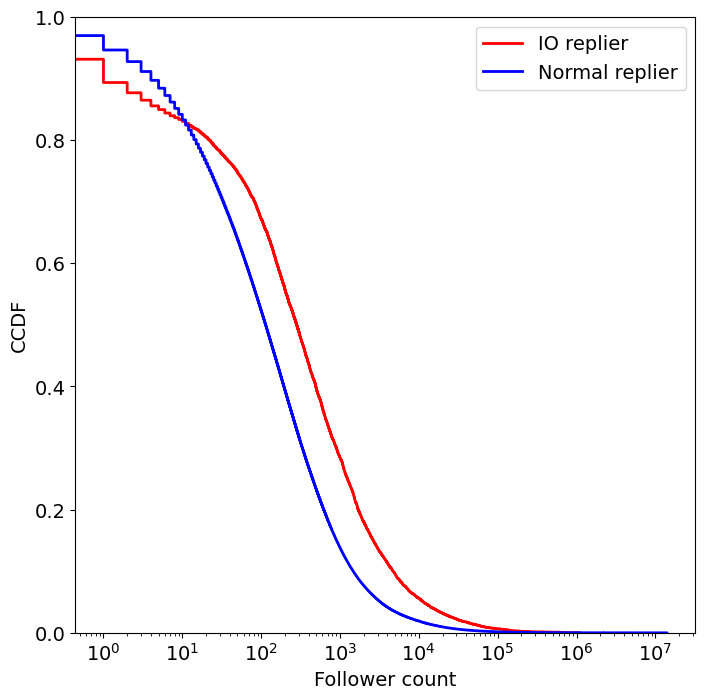

In [6]:
import helper.visualization as viz_hp

importlib.reload(config_hp)
importlib.reload(viz_hp)

# config = config_hp.config()
# plot_path = config['PLOTS']
# reply_plot_path = plot_path['reply_plot_path']

df_all_pos_men = df_merge.loc[df_merge['replier_label'] == 1]
df_all_neg_men = df_merge.loc[df_merge['replier_label'] == 0]

parameters = {
        'data': [df_all_pos_men, 
                 df_all_neg_men
                ],
        'fontsize': 14,
        'complementary': True,
        'columns': [
            {'column': 'followers_count',
             'label': 'IO replier',
            },{
            'column': 'followers_count',
             'label': 'Normal replier'
            },
        ],
        'xlabel': 'Follower count',
        'ylabel': 'CCDF',
        'legend_location': 'upper right',
        # 'log_yscale': True,
        'log_xscale': True,
        'save': {
            'path': './',
            'filename': 'CCDF_follower_count_replier.png'
        },
        'random_color': False
}


viz_hp.ccdf(parameters)

.//CCDF_following_count_replier.png
./CCDF_following_count_replier.png


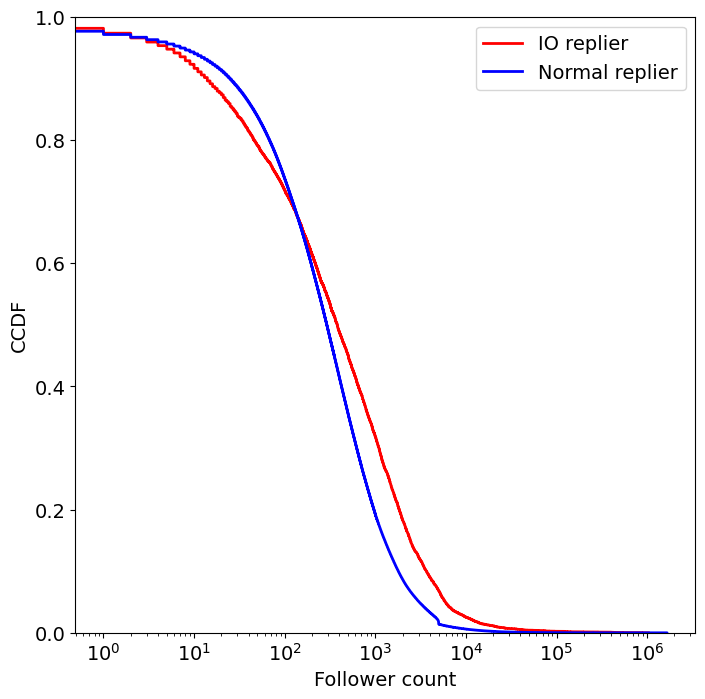

In [7]:
import helper.visualization as viz_hp

importlib.reload(config_hp)
importlib.reload(viz_hp)

# config = config_hp.config()
# plot_path = config['PLOTS']
# reply_plot_path = plot_path['reply_plot_path']

df_all_pos_men = df_merge.loc[df_merge['replier_label'] == 1]
df_all_neg_men = df_merge.loc[df_merge['replier_label'] == 0]

parameters = {
        'data': [df_all_pos_men, 
                 df_all_neg_men
                ],
        'fontsize': 14,
        'complementary': True,
        'columns': [
            {'column': 'following_count',
             'label': 'IO replier',
            },{
            'column': 'following_count',
             'label': 'Normal replier'
            },
        ],
        'xlabel': 'Follower count',
        'ylabel': 'CCDF',
        'legend_location': 'upper right',
        # 'log_yscale': True,
        'log_xscale': True,
        'save': {
            'path': './',
            'filename': 'CCDF_following_count_replier.png'
        },
        'random_color': False
}


viz_hp.ccdf(parameters)

In [5]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 881918 entries, 0 to 881917
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   replier_userid   881918 non-null  object        
 1   replier_label    881918 non-null  int64         
 2   created_at       881918 non-null  object        
 3   following_count  881918 non-null  float64       
 4   followers_count  881918 non-null  float64       
 5   year             881918 non-null  object        
 6   year_filter      881918 non-null  datetime64[ns]
 7   created_at_year  881918 non-null  datetime64[ns]
 8   age              881918 non-null  float64       
 9   followers_ratio  881918 non-null  float64       
 10  following_ratio  881918 non-null  float64       
dtypes: datetime64[ns](2), float64(5), int64(1), object(3)
memory usage: 80.7+ MB


In [7]:
df_merge['replier_label'].unique()

array([1, 0])

In [14]:
df_io = df_merge.loc[df_merge['replier_label'] == 1]
df_non_io = df_merge.loc[df_merge['replier_label'] == 0]

print('Mean followers ratio : IO : ', df_io['followers_ratio'].mean())
print('Mean followers ratio : Non IO :', df_non_io['followers_ratio'].mean())
print('****************')
print('Mean following ratio : IO: ', df_io['following_ratio'].mean())
print('Mean following ratio : Non IO: ', df_non_io['following_ratio'].mean())

Mean followers ratio : IO :  698.4674980496866
Mean followers ratio : Non IO : 190.39355849843528
****************
Mean following ratio : IO:  482.5403879629286
Mean following ratio : Non IO:  113.46782743788482


#### **Statistical Test**

In [110]:
import helper.stat_helper as stat_hp
importlib.reload(stat_hp)

df_all_pos_men = df_merge.loc[df_merge['replier_label'] == 1]
df_all_neg_men = df_merge.loc[df_merge['replier_label'] == 0]

print('followers_ratio \n')
stat_hp.KS_test(df_all_pos_men['followers_ratio'], 
                df_all_neg_men['followers_ratio'])


stat_hp.mann_whitneyu_test(df_all_pos_men['followers_ratio'], 
                           df_all_neg_men['followers_ratio'])


print('Following ratio \n')
stat_hp.KS_test(df_all_pos_men['following_ratio'], 
                df_all_neg_men['following_ratio'])


stat_hp.mann_whitneyu_test(df_all_pos_men['following_ratio'], 
                           df_all_neg_men['following_ratio'])


followers_ratio 

KS test statistic: 0.3304088760710386
p-value: 0.0
Mann-Whitney U statistic: 4596458951.5
p-value: 0.0
Following ratio 

KS test statistic: 0.2734118454503501
p-value: 0.0
Mann-Whitney U statistic: 4438546634.0
p-value: 0.0


#### **Visualization**

/N/slate/potem/project/infoOps-strategy/plots/reply_characterization/CDF_follower_ratio_replier.png
/N/slate/potem/project/infoOps-strategy/plots/reply_characterization/CDF_follower_ratio_replier.png


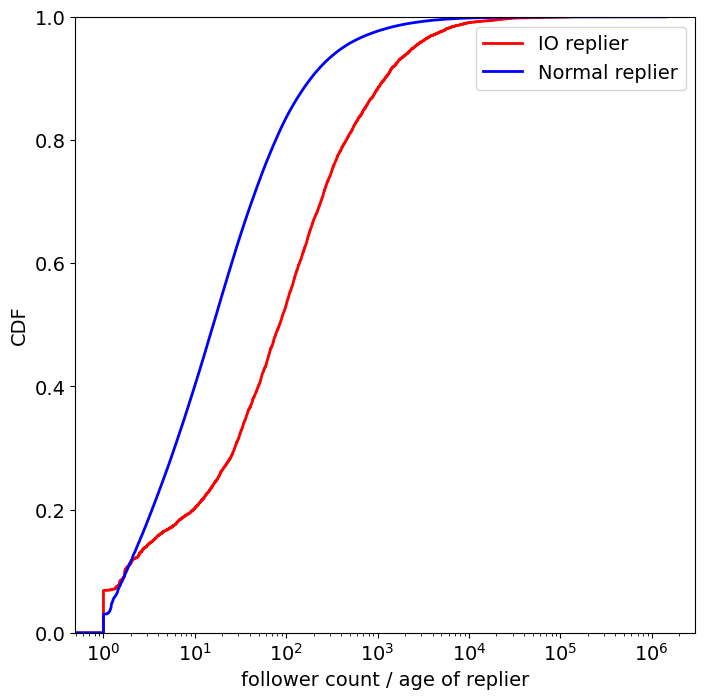

In [111]:
import helper.visualization as viz_hp

importlib.reload(config_hp)
importlib.reload(viz_hp)

config = config_hp.config()
plot_path = config['PLOTS']
reply_plot_path = plot_path['reply_plot_path']

df_all_pos_men = df_merge.loc[df_merge['replier_label'] == 1]
df_all_neg_men = df_merge.loc[df_merge['replier_label'] == 0]

parameters = {
        'data': [df_all_pos_men, 
                 df_all_neg_men
                ],
        'fontsize': 14,
        'complementary': False,
        'columns': [
            {'column': 'followers_ratio',
             'label': 'IO replier',
            },{
            'column': 'followers_ratio',
             'label': 'Normal replier'
            },
        ],
        'xlabel': 'follower count / age of replier',
        'ylabel': 'CDF',
        'legend_location': 'upper right',
        # 'log_yscale': True,
        'log_xscale': True,
        'save': {
            'path': reply_plot_path,
            'filename': 'CDF_follower_ratio_replier.png'
        },
        'random_color': False
}


viz_hp.ccdf(parameters)

In [ ]:
#### Comparatively higher follower count

/N/slate/potem/project/infoOps-strategy/plots/reply_characterization/CDF_following_ratio_replier.png
/N/slate/potem/project/infoOps-strategy/plots/reply_characterization/CDF_following_ratio_replier.png


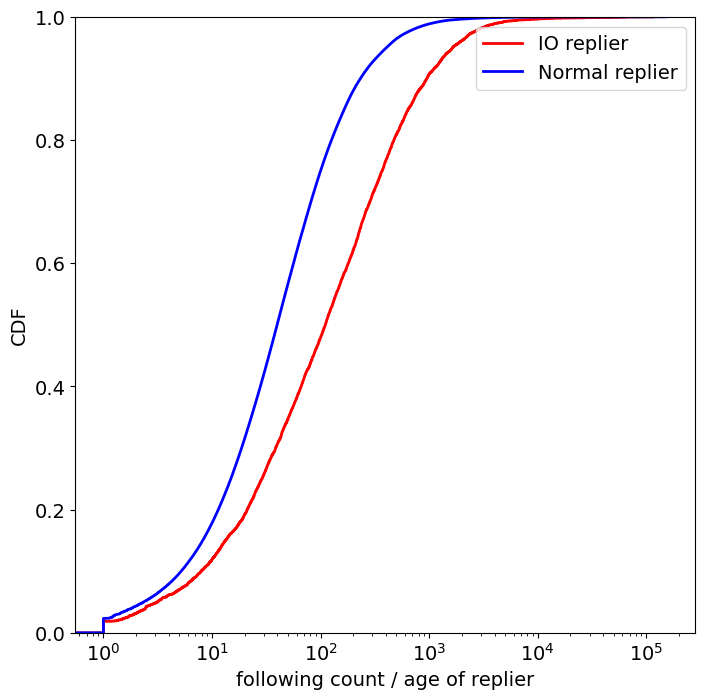

In [117]:
import helper.visualization as viz_hp

importlib.reload(config_hp)
importlib.reload(viz_hp)

config = config_hp.config()
plot_path = config['PLOTS']
reply_plot_path = plot_path['reply_plot_path']

df_all_pos_men = df_merge.loc[df_merge['replier_label'] == 1]
df_all_neg_men = df_merge.loc[df_merge['replier_label'] == 0]

parameters = {
        'data': [df_all_pos_men, 
                 df_all_neg_men
                ],
        'fontsize': 14,
        'complementary': False,
        'columns': [
            {'column': 'following_ratio',
             'label': 'IO replier',
            },{
            'column': 'following_ratio',
             'label': 'Normal replier'
            },
        ],
        'xlabel': 'following count / age of replier',
        'ylabel': 'CDF',
        'legend_location': 'upper right',
        # 'log_yscale': True,
        'log_xscale': True,
        'save': {
            'path': reply_plot_path,
            'filename': 'CDF_following_ratio_replier.png'
        },
        'random_color': False
}


viz_hp.ccdf(parameters)

In [122]:
#### Comparatively larger following count as well

#### **Statistics**

[1 0]
here
After PCA shape  (881918, 2)
Xtrain:  705534
Xtrain shape:  (705534, 2)
Xtest:  176384
Ytrain:  705534
Ytest:  176384
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    174850
           1       0.23      0.01      0.02      1534

    accuracy                           0.99    176384
   macro avg       0.61      0.50      0.51    176384
weighted avg       0.98      0.99      0.99    176384

[[174800     50]
 [  1519     15]]
Mean Accuracy: 0.991 (+/- 0.000)
Mean Precision: 0.347 (+/- 0.064)
Mean Recall: 0.017 (+/- 0.003)
Mean F1-Score: 0.032 (+/- 0.007)


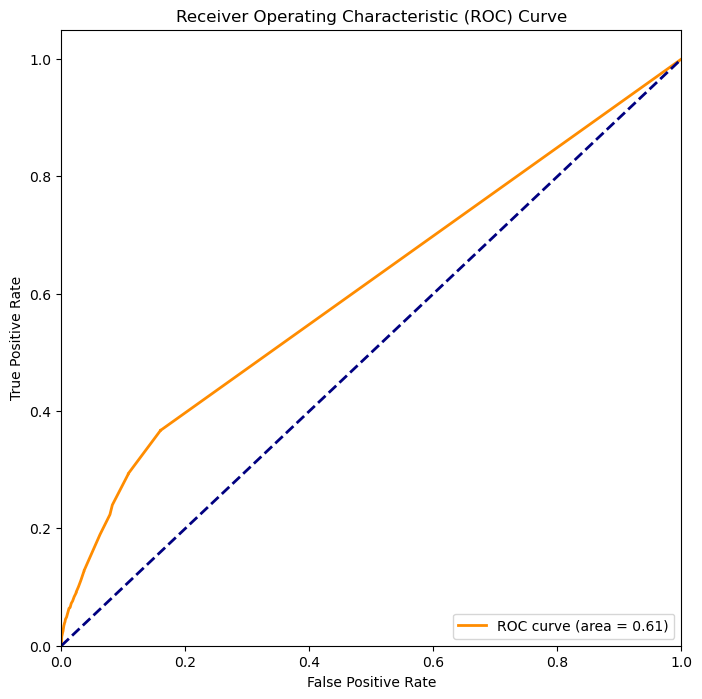

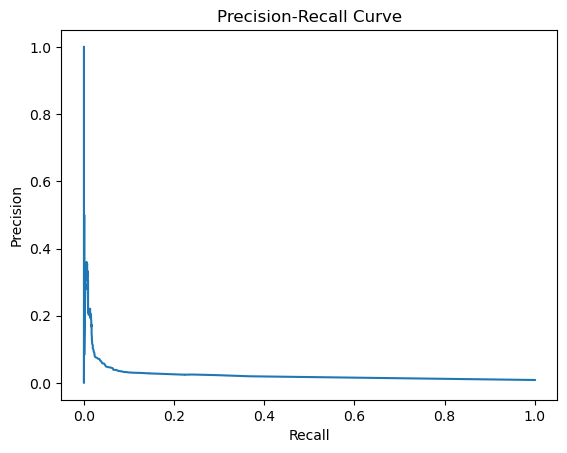

In [3]:
import helper.stat_helper as stat_hp
importlib.reload(stat_hp)

config = config_hp.config()
user_processed = config['USER_PROCESSED']

follow_following_ratio = user_processed['follow_following_ratio']

df_merge = pd.read_pickle(follow_following_ratio)

config = config_hp.config()
plot_path = config['PLOTS']
reply_plot_path = plot_path['reply_plot_path']

filename = os.path.join(reply_plot_path,
                        'ROC_follower_following.png'
                       )

df_result = stat_hp.run_imbalanced_model(df_merge[['replier_userid',
                                                    'replier_label',
                                                    'followers_ratio',
                                                    'following_ratio'
                                                   ]],
                                         columns_not_include=[],
                                         y_column = 'replier_label',
                                         roc_filename=filename,
                                         cross_validation_file='follower_following_ratio.txt',
                                         model_type=None
                                        )

[1 0]
here
After PCA shape  (881918, 2)
Xtrain:  705534
Xtrain shape:  (705534, 2)
Xtest:  176384
Ytrain:  705534
Ytest:  176384
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    174850
           1       0.00      0.00      0.00      1534

    accuracy                           0.99    176384
   macro avg       0.50      0.50      0.50    176384
weighted avg       0.98      0.99      0.99    176384

[[174843      7]
 [  1534      0]]


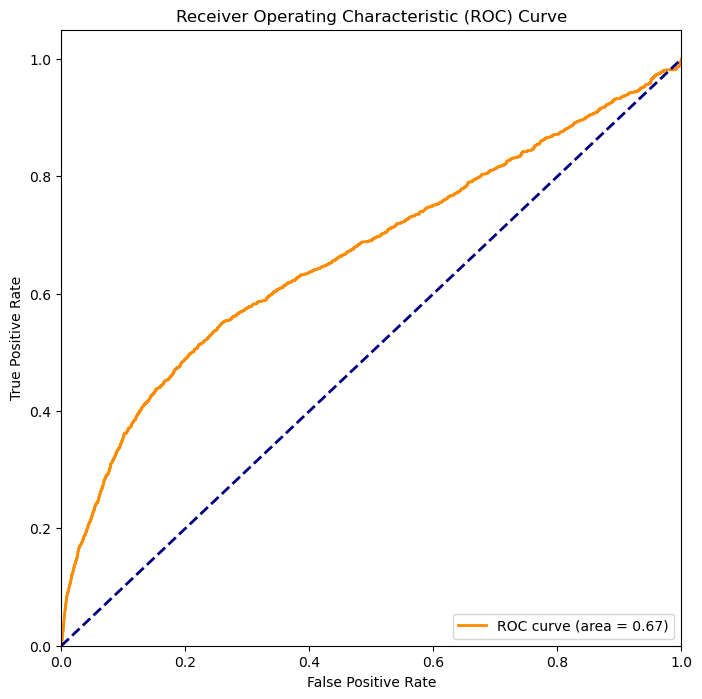

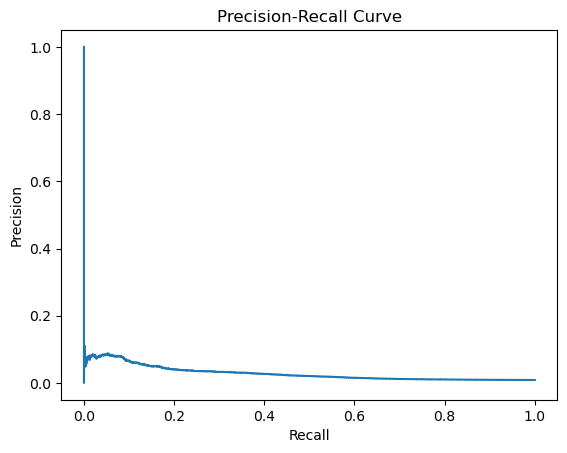

In [152]:
import helper.stat_helper as stat_hp
importlib.reload(stat_hp)

filename_los = os.path.join(reply_plot_path,
                        'ROC_follower_following_logistic.png'
                       )
df_result = stat_hp.run_imbalanced_model(df_merge[['replier_userid',
                                                    'replier_label',
                                                    'followers_ratio',
                                                    'following_ratio'
                                                   ]],
                                         columns_not_include=[],
                                         y_column = 'replier_label',
                                         roc_filename=filename_los,
                                         cross_validation_file='follower_following_ratio_logistic.txt',
                                         model_type='logistic'
                                        )